# Matched Filtering Tutorial

This tutorial introduces matched filter in the context of detecting gravitational waves with LIGO. 

It borrows from a problem set developed by Christopher Berry.

Author: Maya Fishbach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Before we begin - download the [LIGO data](https://northwestern.box.com/s/qpd1m5gkdwtqtflesx7bf19oz6fbixl7) necessary for this notebook. This download may take a bit of time.

## Problem 1) Detector Noise Curves

Read in the Hanford (H1) and Livingston (L1) amplitude spectral densities (ASD) data files (`H1-ASD.txt`, `L1-ASD.txt`).

In [5]:
# Load the ASD data
import os
abspath = '/Users/kylerocha/Private/Matched_Filter_Data/' #point to your local directory containing the data files

H1 = pd.read_csv(os.path.join(abspath,'H1-ASD.txt'), delim_whitespace=True)
L1 = pd.read_csv(os.path.join(abspath,'L1-ASD.txt'), delim_whitespace=True)

H1.columns

Index(['frequency(Hz)', 'ASD(Hz^-0.5)'], dtype='object')

#### Problem 1a
From the ASDs, calculate the power spectral densities (PSDs) $S_n(f)$.

In [6]:
# The amplitude spectral density is the square root of the PSD
H1['PSD'] = H1['ASD(Hz^-0.5)'].values**2
L1['PSD'] = L1['ASD(Hz^-0.5)'].values**2

#### Problem 1b
Plot the PSDs for Hanford and Livingston. 

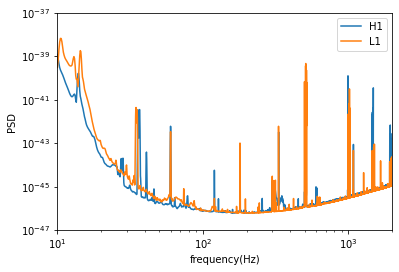

In [9]:
plt.loglog(H1['frequency(Hz)'], H1['PSD'], label='H1')
plt.loglog(L1['frequency(Hz)'], L1['PSD'], label='L1')
plt.ylabel('PSD')
plt.xlabel('frequency(Hz)')
    
plt.legend(loc = 'best')

plt.xlim(10, 2000)
plt.ylim(10**-47,10**-37)

plt.show()

#### Problem 1c

(no code) Looking at your plot of the PSDs, at approximately what frequencies are the detectors most sensitive?

Answer: It looks like around $1\mathrm{e}2$ and $2\mathrm{e}2$ Hz

#### Problem 1d
These ASDs have been calculated from data sampled in the time domain. What is the maximum frequency of the ASDs? What does this imply for the minimum sampling rate for the time domain data? Explain why.

##### Hint: You can find the actual sampling rate in the [GWOSC Open Data paper](https://arxiv.org/abs/1912.11716). 

In [14]:
min_sampling_rate = np.max( H1['frequency(Hz)'].values )/2

print('The minimum sampling rate is %.f'%(min_sampling_rate))

The minimum sampling rate is 4096


Answer: 

## Problem 2) datastreams and template waveforms

You have been given three noisy datastreams $h(t)$, each 600 seconds long, for the Hanford and Livingston detectors: `*1-a.txt`, `*1-b.txt` and `*1-c.txt`, where `*` is `H` for Hanford and `L` for Livingston.

These data streams all contain Gaussian noise drawn from the PSDs in Problem 1. They may additionally contain signals from compact binary inspirals.  

In [16]:
# load the data
H1a = pd.read_csv(os.path.join(abspath,'H1-a.txt'), delim_whitespace=True)
H1b = pd.read_csv(os.path.join(abspath,'H1-b.txt'), delim_whitespace=True)
H1c = pd.read_csv(os.path.join(abspath,'H1-c.txt'), delim_whitespace=True)
L1a = pd.read_csv(os.path.join(abspath,'L1-a.txt'), delim_whitespace=True)
L1b = pd.read_csv(os.path.join(abspath,'L1-b.txt'), delim_whitespace=True)
L1c = pd.read_csv(os.path.join(abspath,'L1-c.txt'), delim_whitespace=True)

You have also been given template waveforms $T(t)$ for a binary black hole, neutron star black hole, and binary neutron star coalescence: `bbh-waveform.txt`, `nsbh-waveform.txt` and `bns-waveform.txt`.

In [17]:
#load the waveform templates
bbh = pd.read_csv(os.path.join(abspath,'bbh_waveform.txt'), delim_whitespace=True)
nsbh = pd.read_csv(os.path.join(abspath,'nsbh_waveform.txt'), delim_whitespace=True)
bns = pd.read_csv(os.path.join(abspath,'bns_waveform.txt'), delim_whitespace=True)

#### Problem 2a
Plot the template waveforms $T(t)$. Try zooming into the last one or two seconds before merger (time = 0).

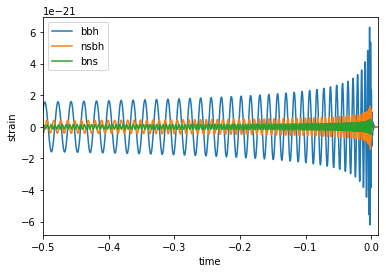

In [30]:
templates = [bbh, nsbh, bns]
labels = ['bbh', 'nsbh', 'bns']

for i, T in enumerate(templates):
    plt.plot(T['time(s)'], T['strain'], label=labels[i])

plt.legend(loc = 'best')
    
plt.xlabel('time')
plt.ylabel('strain')

plt.xlim(-0.5, 0.01) #zoom into the last half second before merger

plt.show()

#### Problem 2b
Plot the datastreams $h(t)$.

Text(0, 0.5, 'strain')

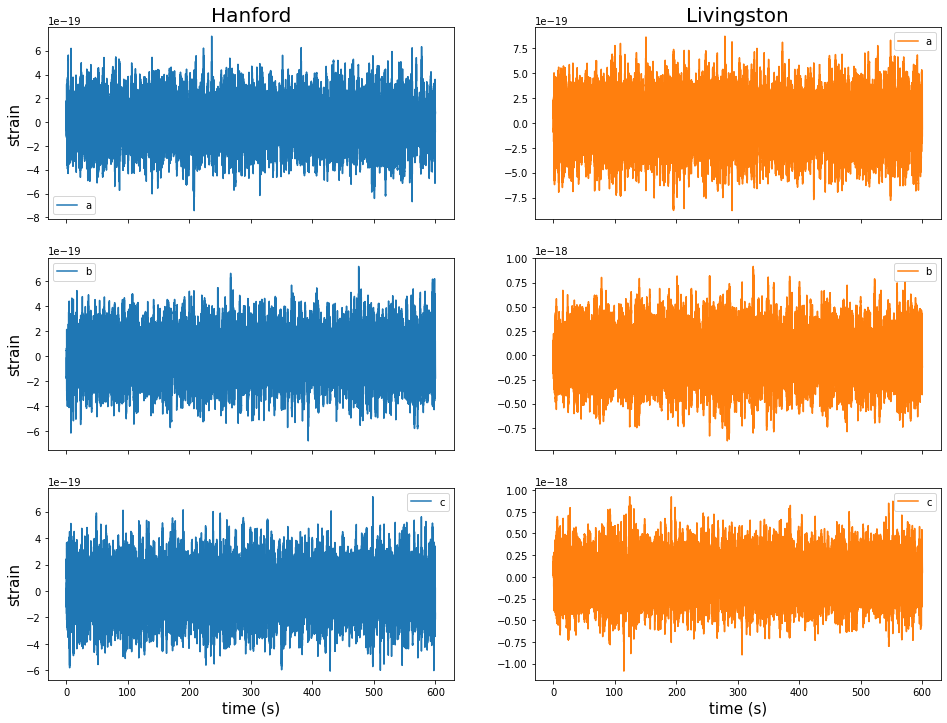

In [37]:
H1_data = [H1a,H1b,H1c]
L1_data = [L1a,L1b,L1c]
labels = ['a','b','c']

# plot the strain data
f, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(16,12))

for i, (h_dat, l_dat, label) in enumerate(zip(H1_data, L1_data, labels)):
    axs[i,0].plot( h_dat['time(s)'], h_dat['strain'], color='C0', label=labels[i])
    axs[i,1].plot( l_dat['time(s)'], l_dat['strain'], color='C1', label=labels[i])
    
    axs[i,0].legend(); axs[i,1].legend()

# label plots
axs[0,0].set_title('Hanford', fontsize=20)
axs[0,1].set_title('Livingston', fontsize=20)

axs[2,0].set_xlabel('time (s)', fontsize=15)
axs[2,1].set_xlabel('time (s)', fontsize=15)

axs[0,0].set_ylabel('strain', fontsize=15)
axs[1,0].set_ylabel('strain', fontsize=15)
axs[2,0].set_ylabel('strain', fontsize=15)

###complete

Can you identify the presence of signals by eye?

Answer:

## Problem 3) Matched filter signal-to-noise ratio (SNR) time series

Using template waveforms $T(t)$, we will calculate and plot the matched filter SNR  as a function of the time shift $\tau$ between the template $T(t)$ and the data $h(t)$. We will repeat this for each of the three templates in each of the three datastreams, looking for peaks in the SNR time series that indicate the presence of gravitational-wave signals.

#### NOTE 1: 
We will first need to Fourier transform both the template $T(t)$ and the data $h(t)$. Do not worry about normalizing your Fourier transforms, as we are only interested in qualitative results here.

##### NOTE 2: 
To do the SNR calculation as a function of the time shift $\tau$, we will need the template to be the same length of the time as the data. There are two ways to achieve this: 

OPTION A: Artificially increase the length of the template waveform by zero-padding the template, such that the template is the same length of time as the data.

OPTION B: Look at a small chunk of data at a time, taking chunks of the data with time durations equal to the template. Perform the SNR calculation by "sliding" the template across the shortened data. 

##### Here, we will go with the method in which we zero-pad the template

#### Problem 3a
Zero-pad the BBH, NSBH, and BNS templates so that the templates are the same length as the H1-(a,b,c) & L1-(a,b,c) datastreams. The data from H1-(a,b,c) & L1-(a,b,c) are the same size, so the padding on each template is the same regardless of the datastream.

In [105]:
#Here we pad the template by placing zeros at the end
all_lengths =  np.concatenate([list(len(i) for i in data) for data in [H1_data, L1_data]])
data_length = list(set(all_lengths)).pop()

def pad_template(template):
    size_diff = data_length-len(template)
    times = template['time(s)'].values
    delta_t = (times[1] - times[0])
    
    extra_times = np.arange( times[0], times[0]+(delta_t*size_diff), delta_t )
    extra_strains = np.zeros_like(extra_times)
    
    df = pd.DataFrame()
    df['time(s)'] = extra_times
    df['strain'] = extra_strains
    
    return pd.concat( [df, template] )
    
padded_bbh = pad_template(bbh)
padded_bns = pad_template(bns)
padded_nsbh = pad_template(nsbh)

# print( len(bbh), len(bns), len(nsbh) )
# print(len(padded_bbh), len(padded_bns), len(padded_nsbh), len(H1_data[0]))

padded_nsbh

,time(s),strain
0,-45.246094,0.000000e+00
1,-45.245850,0.000000e+00
2,-45.245605,0.000000e+00
3,-45.245361,0.000000e+00
4,-45.245117,0.000000e+00
...,...,...
185393,0.015869,3.223872e-26
185394,0.016113,-6.950770e-27
185395,0.016357,1.187905e-26
185396,0.016602,-3.812388e-27


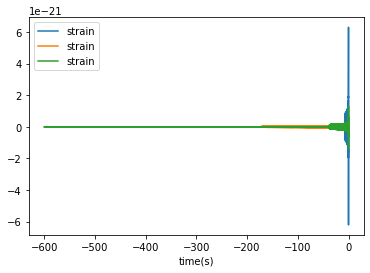

In [64]:
fig, ax = plt.subplots(1,1)
padded_bbh.plot(x='time(s)', y='strain', ax=ax)
padded_bns.plot(x='time(s)', y='strain', ax=ax)
padded_nsbh.plot(x='time(s)', y='strain', ax=ax)
plt.show()

#### Problem 3b

Compute the Fourier transform the templates and plot the Fourier-transformed templates $\tilde{T}(f)$ as a function of frequency. Since the templates are all real, you only need to plot the positive Fourier frequencies and the magnitude of the Fourier transform.

Notice that the sampling rate is the same for all the templates (and all the timestreams), so the sampled frequencies are the same. (In other words, since the time bins are the same, the frequency bins are the same.)

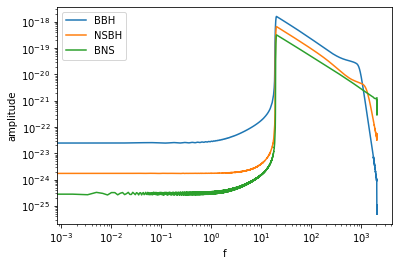

In [104]:
#first compute the corresponding frequency bins for the Fourier transform
times = H1_data[0]['time(s)'].values

sample_spacing = times[1] - times[0]
window_length = data_length
freq = np.fft.fftfreq(window_length, d=sample_spacing)

#now take the Fourier transforms of the templates

Tf_bbh = np.fft.fft(padded_bbh['strain']) #Fourier transform of the BBH padded template
Tf_nsbh = np.fft.fft(padded_nsbh['strain']) #Fourier transform of the NSBH padded template
Tf_bns = np.fft.fft(padded_bns['strain']) #Fourier transform of the BNS padded template

#select the positive frequencies and plot in log-log space

sel = freq >= 0

labels = ['BBH', 'NSBH', 'BNS']
for i, Tf in enumerate([Tf_bbh, Tf_nsbh, Tf_bns]):
    plt.loglog(freq[sel], np.abs(Tf[sel]), label=labels[i])

plt.legend(loc = 'best')

plt.ylabel('amplitude')
plt.xlabel('f')
plt.show()

Most of the power comes from where we are the most sensitive - 10 - 1000 Hz.

#### Problem 3c

Compute the matched filter signal-to-noise ratio timeseries between the templates and the datastreams. Start by computing the matched filter SNR timeseries between the BBH template and the "(a) datastream" in the Hanford detector (H1-a).

##### Note: we need to interpolate the PSDs so that we can evaluate them at the same frequencies as the templates and datastreams.

Recall that one can calculate the matched filter signal-to-noise ratio timeseries by taking the inverse Fourier transform of 
$$
\frac{\tilde{T}^*(f) \tilde{h}(f)}{S_n(f)}
$$

where $\tilde{T}^*(f)$ is the complex conjugate of the template in the frequency domain, $\tilde{h}(f)$ is the datastream in the frequency domain, and $S_n(f)$ is the PSD.

In [120]:
def matched_filter_snr(template_Tf, freq_sampled, data_ht, psd):
    """ Compute the matched filter SNR time series
    template_Tf: waveform template in the frequency domain (Tf_bbh, Tf_nsbh, or Tf_bns from Problem 2)
    freq_sampled: frequency bins corresponding to template_Tf, (freq from Problem 2)
    data_ht: the datastream in the time domain, e.g. H1-a, L1-b
    psd: the dataset containing the PSD data from problem 1, either H1 or L1.
    returns: time, SNR values
    """
    
    #evaluate the PSD at the sampled frequencies: 
    #because we are working only with real timeseries, the negative frequencies are the same as the positive frequencies

    psd_interp = np.interp(np.abs(freq_sampled), psd['frequency(Hz)'], psd['PSD'])
    
    #Fourier transform the strain data to the frequency domain
    data_hf = np.fft.fft( data_ht['strain'] )
    
    #compute (unnormalized) matched filter SNR from template_Tf, data_hf, and psd_interp, in the frequency domain
    snr_freq = (template_Tf.conjugate()* data_hf)/psd_interp
    
    #inverse Fourier transform snr_freq to the time domain
    snr_time = np.fft.ifft( snr_freq )
    
    return data_ht['time(s)'], np.abs(snr_time)


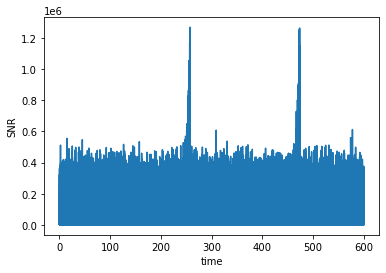

In [122]:
#compute the matched-filter SNR timeseries between the BBH template and H1-a

time, snr_time = matched_filter_snr( Tf_bbh, freq, H1_data[0], H1 )

#plot the timeseries
plt.plot(time, snr_time)

plt.xlabel('time')
plt.ylabel('SNR')
plt.show()

#### Problem 3d
Plot the SNR timeseries for each template in each of the (a), (b) and (c) datastreams, in each detector (18 combinations total). Do you see spikes in the SNR value as a function of the time shift? Which waveform signals are embedded within which datastreams? 

##### Note: each datastream may contain multiple signals.

In [ ]:
#complete

Which waveform signals are embedded within which datastreams? 

Answer:

#### Problem 3e
Using the results from part (d), overplot the signal time-domain waveforms over the datastreams that contain them. You can do this just for H1 datastreams, and just for one signal in each datastream. Your results should illustrate the power of matched filtering.  

##### Note: think about how the zero time $\tau = 0$ is defined. 

In [ ]:
# first we need to calculate the time at which the SNR timeseries peaks. We pick the loudest peak.

def calculate_tau_maxSNR(#complete
    
    return tau
    
tau_a = calculate_tau_maxSNR(#complete #time at which the correct template peaks in the H1a datastream

tau_b = calculate_tau_maxSNR(#complete #time at which the correct template peaks in the H1b datastream

tau_c = calculate_tau_maxSNR(#complete #time at which the correct template peaks in the H1c datastream

In [ ]:
times = H1a['time(s)']

#make the plot for H1-a
plt.title("Datastream a")

plt.plot(times, H1a['strain']) #plot the datastream
plt.plot(#complete #overplot the correct template with the correct timelag 
plt.xlabel(#complete
plt.ylabel(#complete
plt.xlim(0, 600)
plt.show()

#make the plot for H1-b
plt.title("Datastream b")
plt.plot(times, H1b['strain'])
plt.plot(#complete #overplot the correct template with the correct timelag 
plt.xlabel(#complete
plt.ylabel(#complete
plt.xlim(0, 600)
plt.show()

#make the plot for H1-c
plt.title("Datastream c")
plt.plot(times, H1c['strain'])
plt.plot(#complete #overplot the correct template with the correct timelag 
plt.xlabel(#complete
plt.ylabel(#complete
plt.xlim(0, 600)
plt.show()

### Problem 4 (challenge): visualize data

Experiment with whitening and bandpassing the data. This can make signals easier to see (for visualization purposes, as our eyes are not as good as matched filtering). As an example, have a look at Figure 3 of the [LIGO & Virgo Data Analysis Guide](https://arxiv.org/abs/1908.11170).

#### Problem 4a 
Remake the plots from Problem 3e using whitened data.

In [ ]:
#complete

#### Problem 4b
Experiment with bandpassing the whitened data (e.g. using a Butterworth filter) to remove the noisiest frequencies, and remake some plots from Problem 3e.

In [ ]:
#complete

#### Problem 4c
Experiment with making time-frequency spectograms to visualize the data. Check out the [Q-transform](https://gwpy.github.io/docs/stable/examples/timeseries/qscan.html) from `gwpy`. 

In [ ]:
#complete